<a href="https://colab.research.google.com/github/ramanarayanmn/Deep-Learning/blob/master/convnets_using_PreTrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  input_shape = (150,150,3),
                  include_top = False)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_dir = '/content/drive/My Drive/cats_and_dogs_small/train'
validation_dir = '/content/drive/My Drive/cats_and_dogs_small/validation'
test_dir = '/content/drive/My Drive/cats_and_dogs_small/test'

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (2000,4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))
test_features = np.reshape(test_features, (1000,4*4*512))

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.7104 - acc: 0.7685 - val_loss: 0.2690 - val_acc: 0.8910
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3339 - acc: 0.8560 - val_loss: 0.2727 - val_acc: 0.8940
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2956 - acc: 0.8900 - val_loss: 0.4890 - val_acc: 0.8030
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2548 - acc: 0.9000 - val_loss: 0.2865 - val_acc: 0.8940
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1976 - acc: 0.9235 - val_loss: 0.2769 - val_acc: 0.8970
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1970 - acc: 0.9260 - val_loss: 0.2607 - val_acc: 0.9030
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1648 - acc: 0.9385 - val_loss: 0.3981 - val_acc: 0.8840
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

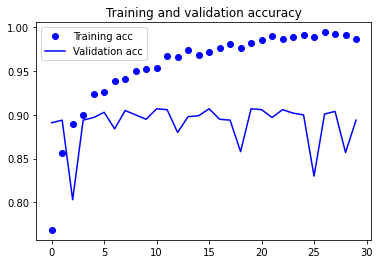

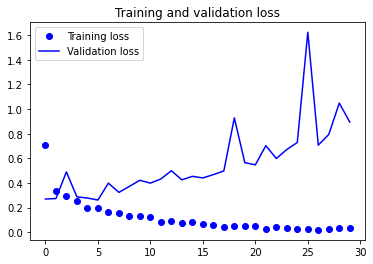

In [ ]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Freezing Conv_base layer

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [14]:

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [15]:
conv_base.trainable = False

In [16]:
print('Total number of trainable layers: ',len(model.trainable_weights))

Total number of trainable layers:  4


In [18]:
## Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 40,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True,
                fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  batch_size = 20,
                  target_size = (150, 150),
                  class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        batch_size = 20,
                        target_size = (150, 150),
                        class_mode = 'binary'
)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 23s - loss: 0.7373 - acc: 0.7020 - val_loss: 0.3567 - val_acc: 0.8320
Epoch 2/30
100/100 - 22s - loss: 0.4633 - acc: 0.7795 - val_loss: 0.3065 - val_acc: 0.8630
Epoch 3/30
100/100 - 22s - loss: 0.4093 - acc: 0.8000 - val_loss: 0.2886 - val_acc: 0.8740
Epoch 4/30
100/100 - 22s - loss: 0.3762 - acc: 0.8195 - val_loss: 0.2628 - val_acc: 0.8830
Epoch 5/30
100/100 - 23s - loss: 0.3554 - acc: 0.8415 - val_loss: 0.2775 - val_acc: 0.8870
Epoch 6/30
100/100 - 22s - loss: 0.3666 - acc: 0.8345 - val_loss: 0.2577 - val_acc: 0.8980
Epoch 7/30
100/100 - 22s - loss: 0.3658 - acc: 0.8340 - val_loss: 0.2516 - val_acc: 0.8890
Epoch 8/30
100/100 - 22s - loss: 0.3576 - acc: 0.8385 - val_loss: 0.2535 - val_acc: 0.8980
Epoch 9/30
100/100 - 22s - loss: 0.3381 - acc: 0.8545 - val_loss: 0.2450 - val_acc: 0.9050
Epoch 10/30
100/100 - 22s - loss: 0.3152 - acc: 0.8530 - val_loss: 0.2342 - val_acc: 0.9060
Epoch

In [19]:
model.save('cats_and_dogs_small_3.h5')


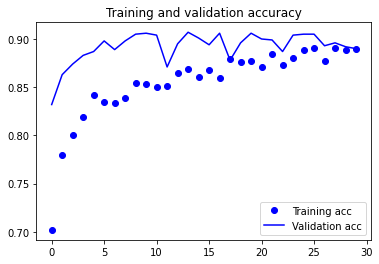

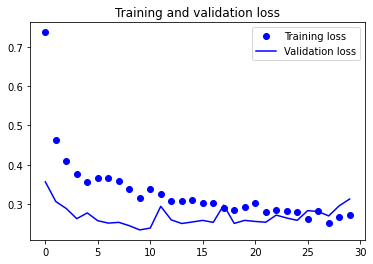

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()